In [1]:
import time,csv
import numpy as np

In [2]:
from TDD.TDD import global_norm
# from TDD.TDD import TDD
# def global_norm(tdd):
#     node=tdd.node
#     weight=tdd.weight

#     if node.key==-1:
#         return tdd

#     h=weight
#     tdd_list=[]
#     for i in range (len(node.out_weight)):
#         tdd_list.append(TDD(node.successor[i]))
#         tdd_list[i].weight=h*node.out_weight[i]
#         tdd_list[i]=global_norm(tdd_list[i])

#     from TDD.TDD import normalize
#     new_tdd=normalize(node.key,tdd_list)
#     return new_tdd

In [3]:
from TDD.TDD import Ini_TDD
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num

def STDD_simulation(cir, Benchmark_Name=None, unique_table_reset=True, add_inputs_list=None, optimizer=None):
    n=get_real_qubit_num(cir)
    tn,indices=cir_2_tn(cir)
    #add y indices
    indices2=[]
    for i, item in enumerate(indices):
        indices2.append(item)
        if item[0]=='y':
            num=int(item.replace('y',''))
            # indices2.append('z%i'%num)
    t_start=time.time()
    #add sin cos indices
    sin_str=set()
    cos_str=set()
    for tensor in tn.tensors:
        for element in tensor.data.flatten(): 
            from sympy.core.expr import Expr 
            if isinstance(element,Expr):
                for symbol in element.free_symbols:
                    sin_str.add('sin('+str(symbol)+')')
                    cos_str.add('cos('+str(symbol)+')')
    sin_str=list(sin_str)
    sin_str.sort()
    cos_str=list(cos_str)
    cos_str.sort()
    sym_str=[]
    for i in range(len(sin_str)):
        sym_str.append(sin_str[i])
        sym_str.append(cos_str[i])

    # TDD process
    Ini_TDD(indices2,sym_str,type='TrDD',unique_table_reset=unique_table_reset)

    if add_inputs_list:
        from TDD.TDD_Q import add_inputs
        # add_inputs(tn,[0]*n,n)
        add_inputs(tn,add_inputs_list)

    start_cont=time.time()-t_start
    print('start cont ',start_cont)
    tdd, Max_node_num=tn.cont(optimizer=optimizer,max_node=True)
    cont_time=time.time()-start_cont-t_start
    print('cont complete',cont_time)

    from TDD.TDD import get_unique_table_num as gu1
    from TDD.TrDD.BDD import get_unique_table_num as gu2
    output_dict={'Benchmark Name':Benchmark_Name,
            'Parameter num': len(sin_str),
            'Qubit num.':tn.qubits_num,
            'Gate num.':len(cir.data),
            'Time':cont_time,
            'Node num. max':Max_node_num,
            'Node num. final':tdd.node_number(),
            'gu1':gu1(),
            'gu2':gu2()
    }
    return tdd, output_dict

In [4]:
def STDD_verify(cir, cir2, Benchmark_Name=None, unique_table_reset=True, add_inputs_list=None, optimizer=None):
    n=get_real_qubit_num(cir)
    tn, indices = cir_2_tn(cir.compose(cir2.inverse()))

    t_start=time.time()
    #add sin cos indices
    sin_str=set()
    cos_str=set()
    for tensor in tn.tensors:
        for element in tensor.data.flatten(): 
            from sympy.core.expr import Expr 
            if isinstance(element,Expr):
                for symbol in element.free_symbols:
                    sin_str.add('sin('+str(symbol)+')')
                    cos_str.add('cos('+str(symbol)+')')
    sin_str=list(sin_str)
    sin_str.sort()
    cos_str=list(cos_str)
    cos_str.sort()
    sym_str=[]
    for i in range(len(sin_str)):
        sym_str.append(sin_str[i])
        sym_str.append(cos_str[i])

    # TDD process
    Ini_TDD(indices,sym_str,type='TrDD',unique_table_reset=unique_table_reset)

    if add_inputs_list:
        from TDD.TDD_Q import add_inputs
        # add_inputs(tn,[0]*n,n)
        add_inputs(tn,add_inputs_list)

    def cont2(tn,l1):
        from TDD.TDD import cont, get_identity_tdd
        max_node_num=0
        tdd=get_identity_tdd()
        l2=len(tn.tensors)-l1
        l=min(l1,l2)
        d=l1-l2
        r=int(l1/l2) if d>0 else int(l2/l1)
        if r == 1:
            for i in range(l):
                tdd1=tn.tensors[-(i+1)+l1].tdd()
                tdd=cont(tdd1,tdd)
                max_node_num=max(max_node_num,tdd.node_number())
                tdd2=tn.tensors[i+l1].tdd()
                tdd=cont(tdd,tdd2)
                max_node_num=max(max_node_num,tdd.node_number())
            if d>0:
                for i in range(d):
                    tdd1=tn.tensors[-(i+l+1)+l1].tdd()
                    tdd=cont(tdd1,tdd)
                    max_node_num=max(max_node_num,tdd.node_number())
            elif d<0:
                for i in range(abs(d)):
                    tdd2=tn.tensors[i+l+l1].tdd()
                    tdd=cont(tdd,tdd2)
                    max_node_num=max(max_node_num,tdd.node_number())
        elif d>0:
            for i in range(l2):
                for j in range(r):
                    tdd1=tn.tensors[-(r*i+j+1)+l1].tdd()
                    tdd=cont(tdd1,tdd)
                    max_node_num=max(max_node_num,tdd.node_number())
                tdd2=tn.tensors[i+l1].tdd()
                tdd=cont(tdd,tdd2)
                max_node_num=max(max_node_num,tdd.node_number())
            d2=l1-r*l2
            if d2 !=0:
                for i in range (d2):
                    tdd1=tn.tensors[-(i+r*l2+1)+l1].tdd()
                    tdd=cont(tdd1,tdd)
                    max_node_num=max(max_node_num,tdd.node_number())
        elif d<0:
            for i in range(l1):
                tdd1=tn.tensors[-(i+1)+l1].tdd()
                tdd=cont(tdd1,tdd)
                max_node_num=max(max_node_num,tdd.node_number())
                for j in range(r):
                    tdd2=tn.tensors[r*i+j+l1].tdd()
                    tdd=cont(tdd,tdd2)
                    max_node_num=max(max_node_num,tdd.node_number())
            d2=l2-r*l1
            if d2 !=0:
                for i in range(d2):
                    tdd2=tn.tensors[i+(r+1)*l1].tdd()
                    tdd=cont(tdd,tdd2)
                    max_node_num=max(max_node_num,tdd.node_number())
        return tdd, max_node_num

    l1=len(cir.data)

    start_cont=time.time()-t_start
    print('start cont ',start_cont)
    tdd, Max_node_num= cont2(tn,l1)
    cont_time=time.time()-start_cont-t_start
    print('cont complete',cont_time)

    from TDD.TDD import get_unique_table_num as gu1
    from TDD.TrDD.BDD import get_unique_table_num as gu2
    output_dict={'Benchmark Name':Benchmark_Name,
            'Parameter num': len(sin_str),
            'Qubit num.':tn.qubits_num,
            'Gate num.':len(cir.data),
            'Time':cont_time,
            'Node num. max':Max_node_num,
            'Node num. final':tdd.node_number(),
            'gu1':gu1(),
            'gu2':gu2()
    }
    return tdd, output_dict

In [5]:
def verify(tdd1,tdd2):
    start_time= time.time()
    # equivalent without global_norm
    if tdd1==tdd2:
        check_time=time.time()-start_time
        output_dict={"check_time":check_time,"equivalence":"equivalent"}
        print(output_dict)
        return output_dict
    elif tdd1.node==tdd2.node:
        check_time=time.time()-start_time
        output_dict={"check_time":check_time,"equivalence":"equivalent_up_to_global_phase"}
        print(output_dict)
        return output_dict
    tddn=global_norm(tdd1)
    tddn2=global_norm(tdd2)
    # equivalent with global_norm
    if tddn==tddn2:
        output_dict={"check_time":check_time,"equivalence":"equivalent"}
        print('global_norm',output_dict)
        return output_dict
    elif tddn.node==tdd2.node:
        check_time=time.time()-start_time
        output_dict={"check_time":check_time,"equivalence":"equivalent_up_to_global_phase"}
        print('global_norm',output_dict)
        return output_dict
    # not equivalent 
    else:
        check_time=time.time()-start_time
        output_dict={"check_time":check_time,"equivalence":"not_equivalent"}
        print(output_dict)
        return output_dict

In [6]:
from qiskit import transpile
from qiskit.circuit import Parameter, QuantumCircuit, library

def circuit_generator(qubit_num=1,reps=1,function_name='TwoLocal'
                    ,basis_gates1=['id', 'rz', 'sx', 'x', 'cx']
                    ,basis_gates2=['h','ry','rz','cx']):

    if function_name=='TwoLocal':
        cir = library.TwoLocal(qubit_num, ['ry'],'cx', entanglement='circular', reps=reps)
    if function_name=='ExcitationPreserving':
        cir = library.ExcitationPreserving(qubit_num, mode='fsim', entanglement='full', reps=reps)
    if function_name=='RealAmplitudes':
        cir = library.TwoLocal(qubit_num, ['rx'],'cx', entanglement='full', reps=reps)
    if function_name=='EfficientSU2':
        cir = library.TwoLocal(qubit_num, ['rx','h'],'cx', entanglement='circular', reps=reps)

    cir=transpile(cir,basis_gates=basis_gates1)
    cir2=transpile(cir,basis_gates=basis_gates2)

    return cir,cir2,'%s_%i_%i'%(function_name,qubit_num,reps)

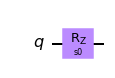

In [7]:
s0=Parameter('s%i'%0)
simple=QuantumCircuit(1)
simple.rz(s0,0)
# simple.x(0)
simple.draw('mpl')

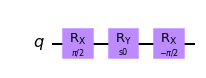

In [8]:
simple2=QuantumCircuit(1)

simple2.rx(np.pi/2,0)
simple2.ry(s0,0)
simple2.rx(-np.pi/2,0)
# simple2.x(0)
# simple2.rz(s0,0)

simple2.draw('mpl')

In [9]:
def experiment(qubit_num=2,reps=1,function='RealAmplitudes', optimizer=None, file_name=None):
        cir1,cir2,circuit_nam=circuit_generator(qubit_num=qubit_num,reps=reps,function_name=function)
        tdd1,output_dict1=STDD_simulation(cir1, unique_table_reset=True, optimizer=optimizer)
        tdd2,output_dict2=STDD_simulation(cir2, unique_table_reset=False, optimizer=optimizer)
        output_dict3=verify(tdd1,tdd2)
        if file_name:
                with open(file_name, 'a', newline='') as csvfile:
                        fieldnames = ['Benchmark Name','Parameter num.','Qubit num.'
                                ,'Gate num._1','Time_1','Node num. max_1','Node num. final_1','gu1_1','gu2_1'
                                ,'Gate num._2','Time_2','Node num. max_2','Node num. final_2','gu1_2','gu2_2'
                                ,'Check_time','Totol_time','Equivalent']
                        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                        writer.writerow({'Benchmark Name':circuit_nam,'Parameter num.':output_dict1['Parameter num'],'Qubit num.':output_dict1['Qubit num.']
                        ,'Gate num._1':output_dict1['Gate num.'],'Time_1':output_dict1['Time'],'Node num. max_1':output_dict1['Node num. max']
                        ,'Node num. final_1':output_dict1['Node num. final'],'gu1_1':output_dict1['gu1'],'gu2_1':output_dict1['gu2']
                        ,'Gate num._2':output_dict2['Gate num.'],'Time_2':output_dict2['Time'],'Node num. max_2':output_dict2['Node num. max']
                        ,'Node num. final_2':output_dict2['Node num. final'],'gu1_2':output_dict2['gu1'],'gu2_2':output_dict2['gu2']
                        ,'Check_time':output_dict3['check_time'],'Totol_time':output_dict1['Time']+output_dict2['Time']+output_dict3['check_time']
                        ,'Equivalent':output_dict3['equivalence']})
        return {'Benchmark Name':circuit_nam,'Parameter num.':output_dict1['Parameter num'],'Qubit num.':output_dict1['Qubit num.']
                ,'Gate num._1':output_dict1['Gate num.'],'Time_1':output_dict1['Time'],'Node num. max_1':output_dict1['Node num. max']
                ,'Node num. final_1':output_dict1['Node num. final'],'gu1_1':output_dict1['gu1'],'gu2_1':output_dict1['gu2']
                ,'Gate num._2':output_dict2['Gate num.'],'Time_2':output_dict2['Time'],'Node num. max_2':output_dict2['Node num. max']
                ,'Node num. final_2':output_dict2['Node num. final'],'gu1_2':output_dict2['gu1'],'gu2_2':output_dict2['gu2']
                ,'Check_time':output_dict3['check_time'],'Totol_time':output_dict1['Time']+output_dict2['Time']+output_dict3['check_time']
                ,'Equivalent':output_dict3['equivalence']}



In [10]:
tdd1, output_dict=STDD_simulation(simple2)
tdd2, output_dict=STDD_simulation(simple,unique_table_reset=False)
verify(tdd1,tdd2)

start cont  0.011424064636230469
cont complete 0.0036203861236572266
start cont  0.00014853477478027344
cont complete 0.001935720443725586
{'check_time': 3.814697265625e-06, 'equivalence': 'equivalent'}


{'check_time': 3.814697265625e-06, 'equivalence': 'equivalent'}

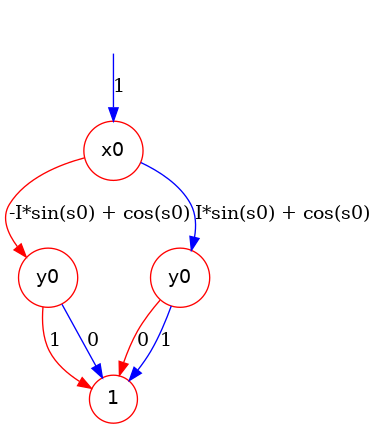

In [11]:
tdd2.show()

In [12]:
tdd, output_dict=STDD_verify(simple, simple2)
output_dict

start cont  0.0004341602325439453
cont complete 0.003764629364013672


{'Benchmark Name': None,
 'Parameter num': 1,
 'Qubit num.': 1,
 'Gate num.': 1,
 'Time': 0.003764629364013672,
 'Node num. max': 4,
 'Node num. final': 4,
 'gu1': 13,
 'gu2': 9}

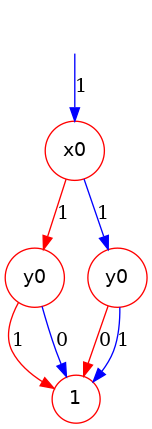

In [13]:
tdd.show()

In [14]:
experiment(qubit_num=5,reps=4,function='RealAmplitudes')

start cont  0.00301361083984375
cont complete 7.422567844390869
start cont  0.003000974655151367
cont complete 0.6852784156799316
{'check_time': 7.3909759521484375e-06, 'equivalence': 'equivalent_up_to_global_phase'}


{'Benchmark Name': 'RealAmplitudes_5_4',
 'Parameter num.': 25,
 'Qubit num.': 5,
 'Gate num._1': 165,
 'Time_1': 7.422567844390869,
 'Node num. max_1': 192,
 'Node num. final_1': 152,
 'gu1_1': 13314,
 'gu2_1': 34773,
 'Gate num._2': 165,
 'Time_2': 0.6852784156799316,
 'Node num. max_2': 192,
 'Node num. final_2': 152,
 'gu1_2': 16402,
 'gu2_2': 34773,
 'Check_time': 7.3909759521484375e-06,
 'Totol_time': 8.107853651046753,
 'Equivalent': 'equivalent_up_to_global_phase'}

In [15]:
cir,cir2,data=circuit_generator(qubit_num=5,reps=4, function_name='RealAmplitudes')

In [16]:
tdd, output_dict=STDD_verify(cir, cir2)
output_dict

start cont  0.11669278144836426
cont complete 0.20437073707580566


{'Benchmark Name': None,
 'Parameter num': 25,
 'Qubit num.': 5,
 'Gate num.': 165,
 'Time': 0.20437073707580566,
 'Node num. max': 26,
 'Node num. final': 16,
 'gu1': 469,
 'gu2': 201}

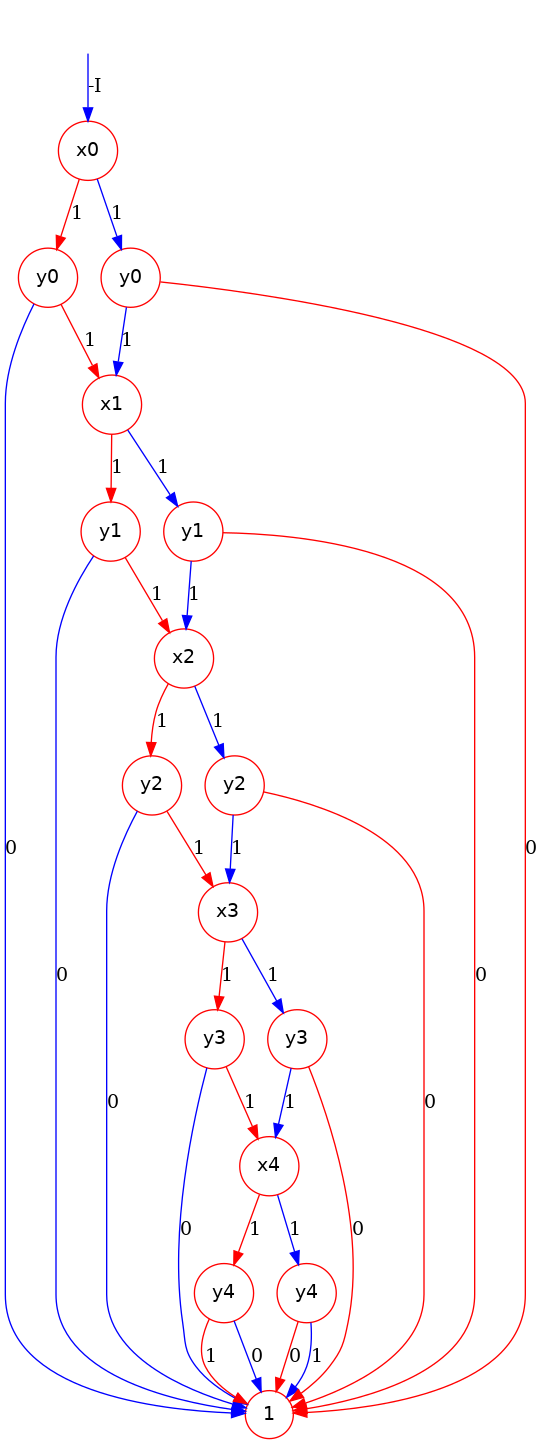

In [17]:
tdd.show()

In [18]:
import sympy

x = sympy.Symbol('x')
y = sympy.Symbol('y')
epi=1e-10
expr = (1e-15 + 2j)*x + (3 + 4j)*x*y

new_expr=0
for term in expr.args:
    # print(term)
    free_symbols=term.free_symbols
    for i in range(len(free_symbols)):
        if i==0:
            coeff = term.coeff(free_symbols.pop())
        else:
            coeff = coeff.coeff(free_symbols.pop())
    if abs(coeff)-abs(coeff.as_real_imag()[0]) < epi:
        coeff=coeff.as_real_imag()[0]
    elif abs(coeff)-abs(coeff.as_real_imag()[1]) < epi:
        coeff=coeff.as_real_imag()[1] * sympy.I
    symbols = term.free_symbols
    terms=1 
    for symbol in symbols:
        terms*=symbol
    # print('term',coeff*terms)
    new_expr+=coeff*terms
print('solution',new_expr)


solution x*y*(3.0 + 4.0*I) + 2.0*I*x


In [19]:

class Tensor:
    def __init__(self,data=[],index=[],name=None,qubits=None):
        self.data=data
        self.index_set=index
        self.name=name
        self.qubits=qubits #This is used only when it represent a quantum gate 
        self._tdd=None
    @property
    def tdd(self):
        return self._tdd
    @tdd.setter
    def tdd(self):
        from TDD.TDD import get_tdd
        return get_tdd(self.data,self.index_set)  

In [20]:
# function_list=['RealAmplitudes','EfficientSU2']
# experiment_setup=[(5,3)]
    
# for qubit_num,reps in experiment_setup:
#     for function in function_list:
#             experiment(qubit_num=qubit_num, reps=reps, function=function, optimizer=None, file_name='STDD benchmark.csv')
        

In [21]:

# with open('STDD cir_partition2 benchmark.csv', 'w', newline='') as csvfile:
#     fieldnames=['Benchmark Name','Parameter num.','Qubit num.'
# ,'Gate num._1','Time_1','Node num. max_1','Node num. final_1','gu1_1','gu2_1'
# ,'Gate num._2','Time_2','Node num. max_2','Node num. final_2','gu1_2','gu2_2'
# ,'Check_time','Totol_time','Equivalent']
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#     writer.writeheader()
